In [1]:
import os
import pandas as pd
import numpy as np

##tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LSTM, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


## text preprocessing modules
from gensim.parsing.preprocessing import remove_stopwords
from gensim.models import Word2Vec
import re
import nltk
nltk.download('punkt')
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score,auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, BatchNormalization, Dropout, Embedding, LayerNormalization, Bidirectional



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('Sentiment_news_dataframe.csv')
df.head()

,Date,Title,URL,sentiment,confidence,Unnamed: 5
0,03/10/17,Amber Enterprises files for Rs555 crore IPO,http://www.livemint.com/Money/DJCTYXYzpDnVT1Ki...,NEGATIVE,-0.987213,NaN
1,21/04/18,No need to divorce this stock ; brokerage sees...,https://www.moneycontrol.com/news/business/sto...,POSITIVE,0.946583,NaN
2,11/07/18,An evening walk down Dalal Street : Trade war ...,https://www.moneycontrol.com/news/business/mar...,POSITIVE,0.967994,NaN
3,09/01/20,Commodity outlook : Refined soya oil jumps 8 %...,https://economictimes.indiatimes.com/markets/c...,NEGATIVE,-0.879617,NaN
4,19/04/17,Nikkei : Tokyo stocks open lower after British...,http://economictimes.indiatimes.com/markets/st...,NEGATIVE,-0.941918,NaN


# Preprocessing

Dropping Columns not required

In [3]:
df = df.drop(['Date','URL','confidence','Unnamed: 5'], axis=1)
df.head()

,Title,sentiment
0,Amber Enterprises files for Rs555 crore IPO,NEGATIVE
1,No need to divorce this stock ; brokerage sees...,POSITIVE
2,An evening walk down Dalal Street : Trade war ...,POSITIVE
3,Commodity outlook : Refined soya oil jumps 8 %...,NEGATIVE
4,Nikkei : Tokyo stocks open lower after British...,NEGATIVE


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      60000 non-null  object
 1   sentiment  60000 non-null  object
dtypes: object(2)
memory usage: 937.6+ KB


Check for null values

In [5]:
df.isnull().sum()


Title        0
sentiment    0
dtype: int64

Drop Duplicates

In [6]:
df = df.drop_duplicates(subset=["Title"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59973 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      59973 non-null  object
 1   sentiment  59973 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [7]:
headline= list(df['Title'])
headline[0:2]

['Amber Enterprises files for Rs555 crore IPO',
 'No need to divorce this stock ; brokerage sees up to 26 % upside on this wedding portal']

In [8]:
### Basic text preprocessing where we remove special characters, any tags etc
#### Removal of stopwords
text=[]
for r in headline:
  text.append(remove_stopwords(r))

text[0:3]

['Amber Enterprises files Rs555 crore IPO',
 'No need divorce stock ; brokerage sees 26 % upside wedding portal',
 'An evening walk Dalal Street : Trade war fears grips equity markets globe ; Nifty ends 10 , 950']

In [9]:
### Removal of tags/special characters

### Basic text preprocessing where we remove special characters, any tags etc
#### Removal of stopwords
#### Removal of tags
text=[]
for r in headline:
  r = re.sub(r'<.*?>',"",r)
  text.append(remove_stopwords(r))

text[0:3]

['Amber Enterprises files Rs555 crore IPO',
 'No need divorce stock ; brokerage sees 26 % upside wedding portal',
 'An evening walk Dalal Street : Trade war fears grips equity markets globe ; Nifty ends 10 , 950']

In [10]:
### Basic text preprocessing where we remove special characters, any tags etc
#### Removal of stopwords
#### Removal of tags
#### Removal of special characters
#### Removal of email id
#### Removal of numbers
text=[]
for r in headline:
  r = re.sub(r'<.*?>',"",r)
  r = re.sub(r'\S+@\S+\s','',r)
  r = re.sub(r'\d+','',r)
  r = re.sub(r'[#$!\*\)\(\\%:;,\'_-]','',r)
  text.append(remove_stopwords(r))

text[0:3]

['Amber Enterprises files Rs crore IPO',
 'No need divorce stock brokerage sees upside wedding portal',
 'An evening walk Dalal Street Trade war fears grips equity markets globe Nifty ends']

# Tokenisation

In [11]:
### Now the reviews are faily clean, we will tokenize the reviews and get word embeddings for these
tokenizer=Tokenizer(num_words=15000,lower=True,oov_token='UNK')# out of vocabulory-oov

Train test split

In [12]:
## Before applying the tokenizer, lets split the data into train test
train_text=text[:len(text)-500]
test_text=text[-500:]
print(len(text),len(train_text),len(test_text))

59973 59473 500


In [13]:
### Now lets tokenize the reviews
tokenizer.fit_on_texts(train_text)

In [14]:
tokenizer.word_index

{'UNK': 1,
 'india': 2,
 'market': 3,
 'rs': 4,
 'us': 5,
 'stocks': 6,
 'says': 7,
 'sensex': 8,
 'nifty': 9,
 'the': 10,
 'bank': 11,
 'growth': 12,
 'rbi': 13,
 'china': 14,
 'economy': 15,
 'trade': 16,
 'indian': 17,
 'live': 18,
 'new': 19,
 'markets': 20,
 'modi': 21,
 'budget': 22,
 'news': 23,
 'global': 24,
 'crore': 25,
 'stock': 26,
 'gold': 27,
 'financial': 28,
 'oil': 29,
 'price': 30,
 'rupee': 31,
 'trump': 32,
 'prices': 33,
 'economic': 34,
 'covid': 35,
 'govt': 36,
 'buy': 37,
 'today': 38,
 'dollar': 39,
 'q': 40,
 'share': 41,
 'sebi': 42,
 'rate': 43,
 'year': 44,
 'coronavirus': 45,
 'express': 46,
 'how': 47,
 'high': 48,
 'report': 49,
 'fund': 50,
 'pm': 51,
 'business': 52,
 'investors': 53,
 'policy': 54,
 'tax': 55,
 'government': 56,
 'week': 57,
 'day': 58,
 'shares': 59,
 'mutual': 60,
 'street': 61,
 'world': 62,
 'funds': 63,
 'gst': 64,
 'time': 65,
 'fy': 66,
 'likely': 67,
 'gdp': 68,
 'ahead': 69,
 'investment': 70,
 'higher': 71,
 'why': 72,
 'b

In [15]:
len(tokenizer.word_index)

27782

# Glove Embeddings

In [16]:
embeddings_index= dict()
glove= open('glove.6B.100d.txt','r',encoding='utf-8') 
for line in glove:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs

glove.close()

In [17]:
len(embeddings_index)

400000

In [48]:
### Create an embedding matrix for the vocabulary created for the reviews 
vocab= len(tokenizer.word_index)+1   #determines the length of the vocabulary by adding one to the maximum index of the tokenizer's word index
embedding_matrix = np.zeros((vocab, 100)) #initializes an embedding matrix where vocab is the length of the vocabulary and 100 is the dimensionality of the pre-trained word embeddings 
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector 
        #iterates over each word in the tokenizer's word index and retrieves the pre-trained embedding vector 
        #for that word from a pre-trained embedding index (GloVe). If the embedding vector is found, it is assigned to the corresponding row in the 
        #embedding matrix (i.e., the ith row, where i is the index of the word in the tokenizer's word index). 
        #If the embedding vector is not found, the corresponding row in the embedding matrix is left as a row of zeros.



In [19]:
embedding_matrix.shape

(27783, 100)

In [20]:
train_indices=tokenizer.texts_to_sequences(train_text) #using a tokenizer to convert a list of text strings into a list of sequences of integers.

In [21]:
train_indices[0:3]

[[4501, 1394, 979, 4, 25, 77],
 [299, 126, 6877, 26, 3678, 192, 1049, 3959, 3960],
 [705, 706, 630, 390, 61, 16, 150, 359, 6359, 152, 20, 3679, 9, 289]]

# Pad Sequences

max_length=64
The pad_sequences() function takes a list of sequences (in this case, train_indices) as input and pads or truncates the sequences to a fixed length. In this case, the maxlen parameter is set to 64, which means that all sequences will be padded or truncated to a length of 64.

If a sequence is shorter than 64 elements, it will be padded with zeros at the end (since padding='post'). If a sequence is longer than 64 elements, it will be truncated to the first 64 elements.

After the padding is applied, the resulting sequences are stored back into the train_indices variable.

The reason for doing this padding is that neural networks usually require inputs to have a fixed size. In this case, all input sequences are of the same length (64), which makes it possible to use them as input to a neural network model.

Without the padding, the sequences might have different lengths, which would make it difficult to use them as input features for a neural network.





In [49]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length=64
train_indices=pad_sequences(train_indices,maxlen=max_length,padding='post')

In [23]:
df['sentiment'].value_counts()

NEGATIVE    29988
POSITIVE    29985
Name: sentiment, dtype: int64

In [50]:
#replace() method is used to replace the string values "POSITIVE" and "NEGATIVE" in the sentiment column with the integer 
#values 1 and 0, respectively. 
df['sentiment'].replace(['POSITIVE','NEGATIVE'],[1,0],inplace=True)
df['sentiment'].value_counts() 
#value_counts() method is used to count the number of occurrences of each unique value in the sentiment column.


0    29988
1    29985
Name: sentiment, dtype: int64

In [25]:
Y=list(df['sentiment'])
train_y=Y[:len(Y)-500]
test_y=Y[-500:]
print(len(train_y),len(test_y))

59473 500


In [26]:
train_indices=np.asarray(train_indices)
train_y=np.asarray(train_y)

In [27]:
test_indices=tokenizer.texts_to_sequences(test_text)
test_indices=pad_sequences(test_indices,maxlen=max_length,padding='post')
test_indices=np.asarray(test_indices)
test_y=np.asarray(test_y)

# Simple RNN with dropouts

Sequential() is a class in the Keras API for building a sequential model in deep learning. The model is a linear stack of layers where each layer is connected to the next layer, forming a sequence of layers.

The Sequential() function initializes an empty sequential model object that can be used to add layers one after the other. Once we have created the model using Sequential(), we can add layers to the model using the add() method.

In [28]:
# defining a sequential neural network model using the Keras API
vocab= len(tokenizer.word_index)+1 #calculates the vocabulary size of the input data 
model= Sequential()
model.add(Embedding(input_dim=vocab,output_dim=100,input_length=max_length)) #input sequences of integers as input and converts them into dense vectors of fixed size
model.add(Dropout(0.3))# dropping at input level to prevent overfitting
model.add(SimpleRNN(32))#SimpleRNN layer has 32 units, which determines the dimensionality of the internal state.
model.add(Dropout(0.3))# another drop out layer added after RNN to prevent overfitting
model.add(Dense(1, activation='sigmoid'))#fully connected layer that produces a single output value between 0 and 1 with use of sigmoid function
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#compile() method is used to compile the model, specifying the loss function ('binary_crossentropy'), the optimizer ('adam'),
# and the evaluation metric ('accuracy').

print(model.summary())# print a summary of the model architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 100)           2778300   
                                                                 
 dropout (Dropout)           (None, 64, 100)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2,782,589
Trainable params: 2,782,589
Non-trainable params: 0
_________________________________________________________________
None


*train_indices is the input data for the model, typically a set of training examples that have been converted into numerical features.

*train_y is the output data for the model, which typically consists of labels or target values that the model is trying to predict.

*epochs specifies the number of times the model will iterate over the entire training dataset during training. Each iteration over the dataset is called an epoch.

*batch_size specifies the number of training examples that the model will use at once to update its parameters during each epoch. The model will use mini-batch stochastic gradient descent to optimize the parameters.

*validation_split specifies the proportion of the training data that will be used for validation during training. In this case, 20% of the training data will be used for validation, and the remaining 80% will be used for actual training.


Epoch 1/10
1487/1487 [==============================] - 91s 60ms/step - loss: 0.6947 - accuracy: 0.5098 - val_loss: 0.6882 - val_accuracy: 0.5498
Epoch 2/10
1487/1487 [==============================] - 93s 62ms/step - loss: 0.6287 - accuracy: 0.6559 - val_loss: 0.5921 - val_accuracy: 0.7041
Epoch 3/10
1487/1487 [==============================] - 88s 59ms/step - loss: 0.5696 - accuracy: 0.7223 - val_loss: 0.5755 - val_accuracy: 0.7153
Epoch 4/10
1487/1487 [==============================] - 87s 59ms/step - loss: 0.5014 - accuracy: 0.7749 - val_loss: 0.5777 - val_accuracy: 0.7205
Epoch 5/10
1487/1487 [==============================] - 90s 61ms/step - loss: 0.4611 - accuracy: 0.8027 - val_loss: 0.5754 - val_accuracy: 0.7258
Epoch 6/10
1487/1487 [==============================] - 88s 59ms/step - loss: 0.4488 - accuracy: 0.8081 - val_loss: 0.5901 - val_accuracy: 0.7209
Epoch 7/10
1487/1487 [==============================] - 88s 59ms/step - loss: 0.4270 - accuracy: 0.8243 - val_loss: 0.6109 -

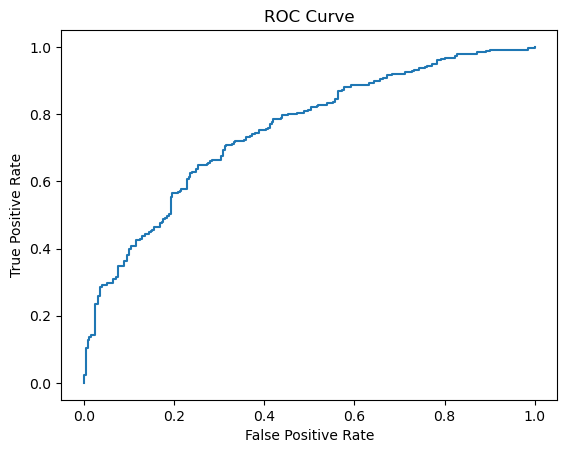

In [30]:
# Train the model
history = model.fit(train_indices, train_y, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_indices, test_y)

# Make predictions
test_pred = model.predict(test_indices)
test_pred_classes = [1 if p > 0.5 else 0 for p in test_pred]
#threshold for classifying an example as positive or negative is set to 0.5. Any predicted output 
#value above 0.5 is classified as a positive example, and any predicted output value below or equal to 0.5 
#is classified as a negative example. 

# Calculate accuracy, precision, recall, and F1 score
train_pred = model.predict(train_indices)
train_pred_classes = [1 if p > 0.5 else 0 for p in train_pred]

train_acc = accuracy_score(train_y, train_pred_classes)
test_acc = accuracy_score(test_y, test_pred_classes)

precision = precision_score(test_y, test_pred_classes)
recall = recall_score(test_y, test_pred_classes)
f1 = f1_score(test_y, test_pred_classes)

# Calculate AUC
fpr, tpr, thresholds = roc_curve(test_y, test_pred)
auc_score = auc(fpr, tpr)

# Print the results
print('Train Accuracy:', train_acc)
print('Test Accuracy:', test_acc)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUC Score:', auc_score)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


# LSTM with dropouts

In [31]:
## Creating the model architecture-- Dropouts with LSTM
vocab= len(tokenizer.word_index)+1 #calculates the vocabulary size of the input data 
model1= Sequential()
model1.add(Embedding(input_dim=vocab,output_dim=100,input_length=max_length))#input sequences of integers as input and converts them into dense vectors of fixed size
model1.add(Dropout(0.3))# dropping at input level to prevent overfitting
model1.add(LSTM(32))#adds a Long Short-Term Memory (LSTM) layer to the model.'32' specifies the number of output units in the LSTM layer
model1.add(Dropout(0.3))#adds another dropout layer after the LSTM layer to further prevent overfitting
model1.add(Dense(1, activation='sigmoid'))#fully connected layer that produces a single output value between 0 and 1 with use of sigmoid function
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#compile() method is used to compile the model, specifying the loss function ('binary_crossentropy'), the optimizer ('adam'),
# and the evaluation metric ('accuracy').
print(model1.summary())# print a summary of the model architecture

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 64, 100)           2778300   
                                                                 
 dropout_2 (Dropout)         (None, 64, 100)           0         
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,795,357
Trainable params: 2,795,357
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/10
1487/1487 [==============================] - 115s 75ms/step - loss: 0.6935 - accuracy: 0.5022 - val_loss: 0.6930 - val_accuracy: 0.5083
Epoch 2/10
1487/1487 [==============================] - 107s 72ms/step - loss: 0.6934 - accuracy: 0.4990 - val_loss: 0.6933 - val_accuracy: 0.4917
Epoch 3/10
1487/1487 [==============================] - 107s 72ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4917
Epoch 4/10
1487/1487 [==============================] - 113s 76ms/step - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6931 - val_accuracy: 0.5083
Epoch 5/10
1487/1487 [==============================] - 112s 75ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4917
Epoch 6/10
1487/1487 [==============================] - 106s 71ms/step - loss: 0.6933 - accuracy: 0.4980 - val_loss: 0.6935 - val_accuracy: 0.4917
Epoch 7/10
1487/1487 [==============================] - 118s 79ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


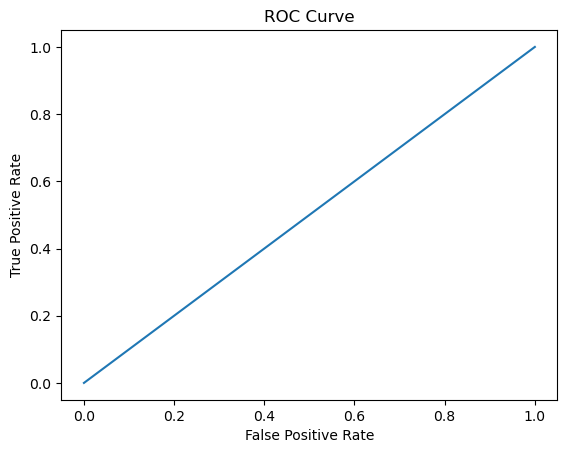

In [32]:
# Train the model
history = model1.fit(train_indices, train_y, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model1.evaluate(test_indices, test_y)

# Make predictions
test_pred = model1.predict(test_indices)
test_pred_classes = [1 if p > 0.5 else 0 for p in test_pred]
#threshold for classifying an example as positive or negative is set to 0.5. Any predicted output 
#value above 0.5 is classified as a positive example, and any predicted output value below or equal to 0.5 
#is classified as a negative example. 

# Calculate accuracy, precision, recall, and F1 score
train_pred = model1.predict(train_indices)
train_pred_classes = [1 if p > 0.5 else 0 for p in train_pred]

train_acc = accuracy_score(train_y, train_pred_classes)
test_acc = accuracy_score(test_y, test_pred_classes)

precision = precision_score(test_y, test_pred_classes)
recall = recall_score(test_y, test_pred_classes)
f1 = f1_score(test_y, test_pred_classes)

# Calculate AUC
fpr, tpr, thresholds = roc_curve(test_y, test_pred)
auc_score = auc(fpr, tpr)

# Print the results
print('Train Accuracy of LSTM model:', train_acc)
print('Test Accuracy of LSTM model:', test_acc)
print('Precision of LSTM model:', precision)
print('Recall of LSTM model:', recall)
print('F1 Score of LSTM model:', f1)
print('AUC Score:', auc_score)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


#  Bidirectional Model 

In [51]:
from tensorflow.keras.layers import Bidirectional,LayerNormalization

## Layer normalization is another regularization technique used to prevent overfitting by normalizing 
## the activations of the neurons in the layer

### Strengthening using bidirectional SimpleRNN

vocab= len(tokenizer.word_index)+1#calculates the vocabulary size of the input data 
model2= Sequential()
model2.add(Embedding(input_dim=vocab,output_dim=100,input_length=max_length))#input sequences of integers as input and converts them into dense vectors of fixed size
model2.add(Dropout(0.3))# dropping at input level to prevent overfitting
model2.add(Bidirectional(SimpleRNN(32)))#adds a Bidirectional SimpleRNN layer to the model.
model2.add(LayerNormalization()) #dds a LayerNormalization layer to the model
model2.add(Dropout(0.3))#adds another dropout layer after the layer Normalisation layer to further prevent overfitting
model2.add(Dense(1, activation='sigmoid'))#fully connected layer that produces a single output value between 0 and 1 with use of sigmoid function
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 64, 100)           2778300   
                                                                 
 dropout_18 (Dropout)        (None, 64, 100)           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               8512      
 nal)                                                            
                                                                 
 layer_normalization_6 (Laye  (None, 64)               128       
 rNormalization)                                                 
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)               

Epoch 1/10
1487/1487 [==============================] - 120s 79ms/step - loss: 0.5866 - accuracy: 0.6867 - val_loss: 0.4986 - val_accuracy: 0.7565
Epoch 2/10
1487/1487 [==============================] - 107s 72ms/step - loss: 0.4188 - accuracy: 0.8108 - val_loss: 0.5134 - val_accuracy: 0.7504
Epoch 3/10
1487/1487 [==============================] - 108s 73ms/step - loss: 0.3045 - accuracy: 0.8733 - val_loss: 0.5861 - val_accuracy: 0.7380
Epoch 4/10
1487/1487 [==============================] - 106s 71ms/step - loss: 0.2217 - accuracy: 0.9119 - val_loss: 0.6760 - val_accuracy: 0.7287
Epoch 5/10
1487/1487 [==============================] - 105s 70ms/step - loss: 0.1755 - accuracy: 0.9327 - val_loss: 0.7575 - val_accuracy: 0.7113
Epoch 6/10
1487/1487 [==============================] - 107s 72ms/step - loss: 0.1437 - accuracy: 0.9462 - val_loss: 0.8155 - val_accuracy: 0.7201
Epoch 7/10
1487/1487 [==============================] - 111s 74ms/step - loss: 0.1258 - accuracy: 0.9529 - val_loss: 0

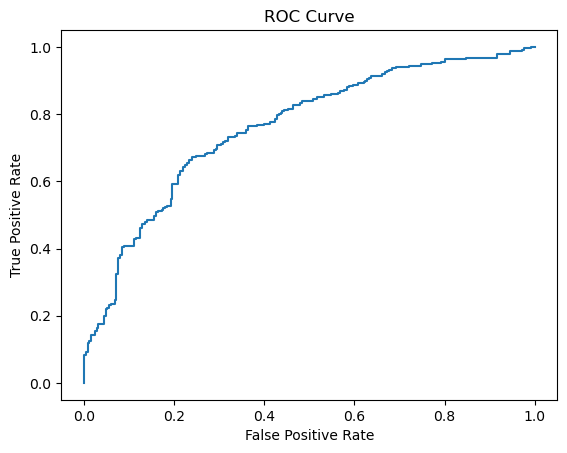

In [38]:
# Train the model
history = model2.fit(train_indices, train_y, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model2.evaluate(test_indices, test_y)

# Make predictions
test_pred = model2.predict(test_indices)
test_pred_classes = [1 if p > 0.5 else 0 for p in test_pred]
#threshold for classifying an example as positive or negative is set to 0.5. Any predicted output 
#value above 0.5 is classified as a positive example, and any predicted output value below or equal to 0.5 
#is classified as a negative example. 

# Calculate accuracy, precision, recall, and F1 score
train_pred = model2.predict(train_indices)
train_pred_classes = [1 if p > 0.5 else 0 for p in train_pred]

train_acc = accuracy_score(train_y, train_pred_classes)
test_acc = accuracy_score(test_y, test_pred_classes)

precision = precision_score(test_y, test_pred_classes)
recall = recall_score(test_y, test_pred_classes)
f1 = f1_score(test_y, test_pred_classes)

# Calculate AUC
fpr, tpr, thresholds = roc_curve(test_y, test_pred)
auc_score = auc(fpr, tpr)

# Print the results
print('Train Accuracy of Bidirectional RNN model:', train_acc)
print('Test Accuracy of Bidirectional RNN model:', test_acc)
print('Precision of Bidirectional RNN model:', precision)
print('Recall of Bidirectional RNN model:', recall)
print('F1 Score of Bidirectional RNN model:', f1)
print('AUC Score:', auc_score)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
